In [5]:
import os
import numpy as np
from PIL import Image
import cv2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, cohen_kappa_score,
                             matthews_corrcoef, roc_curve, precision_recall_curve, auc)
from sklearn.model_selection import train_test_split, learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import zipfile

In [6]:
# Image size for resizing
IMG_SIZE = (64, 64)

In [7]:
# Function to extract ZIP files
def extract_zip(zip_file, extract_path):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extracted {zip_file} to {extract_path}")

In [8]:
# Load dataset and extract features with EDA
def load_data(indoor_path, outdoor_path, method):
    X, y, images = [], [], []
    for img_name in os.listdir(indoor_path):
        if img_name.endswith(('.jpg', '.png')):
            features, img = extract_features(os.path.join(indoor_path, img_name), method)
            if features is not None and img is not None:
                X.append(features)
                y.append(0)
                images.append(img)
    for img_name in os.listdir(outdoor_path):
        if img_name.endswith(('.jpg', '.png')):
            features, img = extract_features(os.path.join(outdoor_path, img_name), method)
            if features is not None and img is not None:
                X.append(features)
                y.append(1)
                images.append(img)
    return np.array(X), np.array(y), np.array(images)

In [23]:
# Perform EDA
def perform_eda(X, y, images, method):
    # Class distribution
    classes, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(6, 4))
    plt.bar(["Indoor", "Outdoor"], counts, color=['blue', 'green'])
    plt.title(f"Class Distribution (Preprocessing: {method})")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.savefig(f"class_distribution_{method}.png")
    plt.show()

    # Image dimensions (before resizing)
    original_dims = []
    base_path = "/content/Training"
    for img_path in [os.path.join(base_path, "museum-indoor", f) for f in os.listdir(os.path.join(base_path, "museum-indoor"))[:5]] + \
                    [os.path.join(base_path, "museum-outdoor", f) for f in os.listdir(os.path.join(base_path, "museum-outdoor"))[:5]]:
        with Image.open(img_path) as img:
            original_dims.append(img.size)
    original_dims = np.array(original_dims)
    print(f"Original Image Dimensions (sample of 10, {method}): Mean Width={np.mean(original_dims[:, 0]):.1f}, Mean Height={np.mean(original_dims[:, 1]):.1f}")
    print(f"Original Image Dimensions Std: Width={np.std(original_dims[:, 0]):.1f}, Height={np.std(original_dims[:, 1]):.1f}")

    # RGB Statistics
    rgb_values = np.array([x for x in X])
    rgb_mean = np.mean(rgb_values, axis=0)
    rgb_std = np.std(rgb_values, axis=0)
    print(f"Mean RGB Values ({method}): R={float(rgb_mean[0]):.1f}, G={float(rgb_mean[1]):.1f}, B={float(rgb_mean[2]):.1f}")
    print(f"Std of RGB Values ({method}): R={float(rgb_std[0]):.1f}, G={float(rgb_std[1]):.1f}, B={float(rgb_std[2]):.1f}")

    # Sample Images with type conversion
    plt.figure(figsize=(12, 4))
    for i in range(4):
        display_img = images[i].copy()
        if method == 'normalize' and display_img.dtype == np.float32:
            display_img = (display_img * 255).astype(np.uint8)
        elif display_img.dtype != np.uint8:
            display_img = display_img.astype(np.uint8)
        plt.subplot(2, 2, i+1)
        plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Sample {['Indoor', 'Outdoor'][y[i]]} ({method})")
        plt.axis('off')
    plt.savefig(f"sample_images_{method}.png")
    plt.show()

In [18]:
# Preprocessing methods
def preprocess_image(img, method):
    if img is None:
        return None
    img = img.copy()
    if method == 'resize_only':
        img = cv2.resize(img, IMG_SIZE)
    elif method == 'normalize':
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0  # Normalize to [0, 1]
    elif method == 'grayscale':
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.expand_dims(img, axis=-1)
    elif method == 'histogram_equalization':
        img = cv2.resize(img, IMG_SIZE)
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])  # Equalize Y channel
        img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img

In [19]:
# Function to extract features based on preprocessing method
def extract_features(image_path, method):
    img = cv2.imread(image_path)
    preprocessed_img = preprocess_image(img, method)
    if preprocessed_img is None:
        return None, None
    if method in ['resize_only', 'normalize', 'histogram_equalization']:
        avg_rgb = np.mean(preprocessed_img, axis=(0, 1))
    elif method == 'grayscale':
        avg_gray = np.mean(preprocessed_img, axis=(0, 1))
        avg_rgb = np.array([avg_gray, avg_gray, avg_gray])
    return avg_rgb, preprocessed_img

In [17]:
# Extended evaluation function with additional metrics and debug
def evaluate_model(y_true, y_pred, y_prob, model_name):
    if len(y_true) != len(y_pred) or len(y_prob) != len(y_true):
        print(f"Shape mismatch: y_true={len(y_true)}, y_pred={len(y_pred)}, y_prob={len(y_prob)}")
        return None, None
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "Cohen's Kappa": cohen_kappa_score(y_true, y_pred),
        "Matthews CC": matthews_corrcoef(y_true, y_pred)
    }
    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix:\n{cm}")
    return metrics, cm

In [20]:
# Plot ROC curve
def plot_roc_curve(y_true, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Plot Precision-Recall curve
def plot_pr_curve(y_true, y_prob, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{model_name} (AUC = {pr_auc:.2f})")

# Bar chart for metric comparison
def plot_metric_comparison(metrics_dict):
    models = list(metrics_dict.keys())
    metrics = list(metrics_dict[models[0]].keys())
    data = np.array([[metrics_dict[model][metric] for metric in metrics] for model in models])
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.15
    index = np.arange(len(models))
    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, data[:, i], bar_width, label=metric)
    plt.xlabel("Models")
    plt.ylabel("Score")
    plt.title("Performance Metrics Comparison Across Models")
    plt.xticks(index + bar_width * (len(metrics) - 1) / 2, models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig("metric_comparison.png")
    plt.close()

# Confusion Matrix Heatmap
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Indoor", "Outdoor"], yticklabels=["Indoor", "Outdoor"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"cm_{model_name.lower().replace(' ', '_')}.png")
    plt.show()
    plt.close()

# Feature Importance (for Random Forest)
def plot_feature_importance(rf_model):
    features = ["Red Avg", "Green Avg", "Blue Avg"]
    importances = rf_model.feature_importances_
    plt.figure(figsize=(8, 5))
    plt.bar(features, importances, color="skyblue")
    plt.title("Feature Importance (Random Forest)")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.savefig("feature_importance_rf.png")
    plt.show()
    plt.close()

# Learning Curve
def plot_learning_curve(estimator, X, y, model_name):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), scoring="accuracy",
        shuffle=True, random_state=42)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes * len(y), train_mean, label="Training Accuracy")
    plt.plot(train_sizes * len(y), val_mean, label="Validation Accuracy")
    plt.fill_between(train_sizes * len(y), train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes * len(y), val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Curve: {model_name}")
    plt.legend(loc="best")
    plt.grid()
    plt.savefig(f"learning_curve_{model_name.lower().replace(' ', '_')}.png")
    plt.show()
    plt.close()

In [26]:
# Main script
def phase_1():
    # Define paths to pre-uploaded ZIP files in Colab
    training_zip = "/content/Museum_Training.zip"
    test_zip = "/content/Museum_Test.zip"

    # Check if ZIP files exist
    if not os.path.exists(training_zip) or not os.path.exists(test_zip):
        print("Error: ZIP files not found in /content/. Please ensure Museum_Training.zip and Museum_Test.zip are uploaded.")
        return

    # Extract ZIP files
    extract_path = "/content"
    extract_zip(training_zip, extract_path)
    extract_zip(test_zip, extract_path)

    # Define paths based on the structure
    train_indoor_path = os.path.join(extract_path, "Training", "museum-indoor")
    train_outdoor_path = os.path.join(extract_path, "Training", "museum-outdoor")
    test_indoor_path = os.path.join(extract_path, "Museum_Validation", "museum-indoor")
    test_outdoor_path = os.path.join(extract_path, "Museum_Validation", "museum-outdoor")

    # Verify paths exist
    for path in [train_indoor_path, train_outdoor_path, test_indoor_path, test_outdoor_path]:
        if not os.path.exists(path):
            print(f"Error: {path} does not exist. Check ZIP structure.")
            return

    # Explore different preprocessing methods for EDA
    preprocessing_methods = ['resize_only', 'normalize', 'grayscale', 'histogram_equalization']
    for method in preprocessing_methods:
        print(f"\nExploring preprocessing method: {method}")
        # Load training data with images for EDA
        X_train_full, y_train_full, images = load_data(train_indoor_path, train_outdoor_path, method)
        print(f"Loaded {len(X_train_full)} training images for {method}.")
        if len(X_train_full) < 10:
            print(f"Error: Too few training images with {method} preprocessing.")
            continue

        # Perform EDA for this method
        perform_eda(X_train_full, y_train_full, images, method)

    # Proceed with resize_only for modeling
    print("\nProceeding with resize_only for modeling and hyperparameter tuning...")
    X_train_full, y_train_full, images = load_data(train_indoor_path, train_outdoor_path, 'resize_only')
    print(f"Loaded {len(X_train_full)} training images for modeling.")
    if len(X_train_full) < 10:
        print("Error: Too few training images to proceed.")
        return

    # Automated train/validation split
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full)

    # Dictionaries to store results
    all_metrics = {}
    all_cms = {}
    prob_dict = {}

    # Hyperparameter tuning for each classifier
    # 1. Random Forest
    rf_params = [
        {"max_depth": 5, "n_estimators": 100, "min_samples_split": 2, "name": "Random Forest (Default)"},
        {"max_depth": 10, "n_estimators": 200, "min_samples_split": 5, "name": "Random Forest (Tuned 1)"},
        {"max_depth": 15, "n_estimators": 150, "min_samples_split": 10, "name": "Random Forest (Tuned 2)"}
    ]
    best_rf = None
    best_val_acc_rf = 0.0
    for config in rf_params:
        rf = RandomForestClassifier(max_depth=config["max_depth"], n_estimators=config["n_estimators"],
                                  min_samples_split=config["min_samples_split"], random_state=42)
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_val)
        val_acc = accuracy_score(y_val, y_pred_rf)
        print(f"\n{config['name']} Validation Accuracy: {val_acc:.4f}")
        if val_acc > best_val_acc_rf:
            best_val_acc_rf = val_acc
            best_rf = rf
    rf = best_rf
    y_pred_rf = rf.predict(X_val)
    y_prob_rf = rf.predict_proba(X_val)[:, 1]
    print(f"Debug - y_val shape: {y_val.shape}, y_pred_rf shape: {y_pred_rf.shape}, y_prob_rf shape: {y_prob_rf.shape}")
    metrics_rf, cm_rf = evaluate_model(y_val, y_pred_rf, y_prob_rf, "Random Forest")
    all_metrics["Random Forest"] = metrics_rf
    all_cms["Random Forest"] = cm_rf
    prob_dict["Random Forest"] = y_prob_rf

    # 2. Decision Tree
    dt_params = [
        {"max_depth": 5, "min_samples_split": 2, "ccp_alpha": 0.0, "name": "Decision Tree (Default)"},
        {"max_depth": 10, "min_samples_split": 5, "ccp_alpha": 0.01, "name": "Decision Tree (Tuned 1)"},
        {"max_depth": 15, "min_samples_split": 10, "ccp_alpha": 0.005, "name": "Decision Tree (Tuned 2)"}
    ]
    best_dt = None
    best_val_acc_dt = 0.0
    for config in dt_params:
        dt = DecisionTreeClassifier(max_depth=config["max_depth"], min_samples_split=config["min_samples_split"],
                                 ccp_alpha=config["ccp_alpha"], random_state=42)
        dt.fit(X_train, y_train)
        y_pred_dt = dt.predict(X_val)
        val_acc = accuracy_score(y_val, y_pred_dt)
        print(f"\n{config['name']} Validation Accuracy: {val_acc:.4f}")
        if val_acc > best_val_acc_dt:
            best_val_acc_dt = val_acc
            best_dt = dt
    dt = best_dt
    y_pred_dt = dt.predict(X_val)
    y_prob_dt = dt.predict_proba(X_val)[:, 1]
    metrics_dt, cm_dt = evaluate_model(y_val, y_pred_dt, y_prob_dt, "Decision Tree (Supervised)")
    all_metrics["Decision Tree"] = metrics_dt
    all_cms["Decision Tree"] = cm_dt
    prob_dict["Decision Tree"] = y_prob_dt

    # 3. Gradient Boosting
    gb_params = [
        {"n_estimators": 100, "max_depth": 3, "learning_rate": 0.1, "name": "Gradient Boosting (Default)"},
        {"n_estimators": 200, "max_depth": 5, "learning_rate": 0.01, "name": "Gradient Boosting (Tuned 1)"},
        {"n_estimators": 150, "max_depth": 7, "learning_rate": 0.05, "name": "Gradient Boosting (Tuned 2)"}
    ]
    best_gb = None
    best_val_acc_gb = 0.0
    for config in gb_params:
        gb = GradientBoostingClassifier(n_estimators=config["n_estimators"], max_depth=config["max_depth"],
                                     learning_rate=config["learning_rate"], random_state=42)
        gb.fit(X_train, y_train)
        y_pred_gb = gb.predict(X_val)
        val_acc = accuracy_score(y_val, y_pred_gb)
        print(f"\n{config['name']} Validation Accuracy: {val_acc:.4f}")
        if val_acc > best_val_acc_gb:
            best_val_acc_gb = val_acc
            best_gb = gb
    gb = best_gb
    y_pred_gb = gb.predict(X_val)
    y_prob_gb = gb.predict_proba(X_val)[:, 1]
    metrics_gb, cm_gb = evaluate_model(y_val, y_pred_gb, y_prob_gb, "Gradient Boosting")
    all_metrics["Gradient Boosting"] = metrics_gb
    all_cms["Gradient Boosting"] = cm_gb
    prob_dict["Gradient Boosting"] = y_prob_gb

    # 4. Semi-Supervised Decision Tree
    sdt_params = [
        {"max_depth": 5, "min_samples_split": 2, "ccp_alpha": 0.0, "name": "Semi-Supervised DT (Default)"},
        {"max_depth": 10, "min_samples_split": 5, "ccp_alpha": 0.01, "name": "Semi-Supervised DT (Tuned 1)"},
        {"max_depth": 15, "min_samples_split": 10, "ccp_alpha": 0.005, "name": "Semi-Supervised DT (Tuned 2)"}
    ]
    best_sdt = None
    best_val_acc_sdt = 0.0
    for config in sdt_params:
        dt_semi = DecisionTreeClassifier(max_depth=config["max_depth"], min_samples_split=config["min_samples_split"],
                                       ccp_alpha=config["ccp_alpha"], random_state=42)
        X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42, stratify=y_train)
        for iteration in range(5):
            dt_semi.fit(X_labeled, y_labeled)
            probs = dt_semi.predict_proba(X_unlabeled)
            y_pseudo = dt_semi.predict(X_unlabeled)
            confident_mask = (probs[:, 0] < 0.15) | (probs[:, 1] > 0.85)
            X_confident = X_unlabeled[confident_mask]
            y_confident = y_pseudo[confident_mask]
            X_labeled = np.vstack((X_labeled, X_confident))
            y_labeled = np.hstack((y_labeled, y_confident))
            X_unlabeled = X_unlabeled[~confident_mask]
            print(f"Iteration {iteration + 1}: Labeled samples = {len(y_labeled)}")
        y_pred_semi = dt_semi.predict(X_val)
        val_acc = accuracy_score(y_val, y_pred_semi)
        print(f"\n{config['name']} Validation Accuracy: {val_acc:.4f}")
        if val_acc > best_val_acc_sdt:
            best_val_acc_sdt = val_acc
            best_sdt = dt_semi
    dt_semi = best_sdt
    y_pred_semi = dt_semi.predict(X_val)
    y_prob_semi = dt_semi.predict_proba(X_val)[:, 1]
    metrics_semi, cm_semi = evaluate_model(y_val, y_pred_semi, y_prob_semi, "Decision Tree (Semi-Supervised)")
    all_metrics["Semi-Supervised DT"] = metrics_semi
    all_cms["Semi-Supervised DT"] = cm_semi
    prob_dict["Semi-Supervised DT"] = y_prob_semi

    # Existing Plots
    plt.figure(figsize=(10, 6))
    plot_roc_curve(y_val, y_prob_dt, "Decision Tree")
    plot_roc_curve(y_val, y_prob_rf, "Random Forest")
    plot_roc_curve(y_val, y_prob_gb, "Gradient Boosting")
    plot_roc_curve(y_val, y_prob_semi, "Semi-Supervised DT")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Validation Set)")
    plt.legend()
    plt.savefig("roc_curves.png")
    plt.show()

    plt.figure(figsize=(10, 6))
    plot_pr_curve(y_val, y_prob_dt, "Decision Tree")
    plot_pr_curve(y_val, y_prob_rf, "Random Forest")
    plot_pr_curve(y_val, y_prob_gb, "Gradient Boosting")
    plot_pr_curve(y_val, y_prob_semi, "Semi-Supervised DT")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (Validation Set)")
    plt.legend()
    plt.savefig("pr_curves.png")
    plt.show()

    plot_metric_comparison(all_metrics)

    # New Plots
    if all_cms:
        for model_name, cm in all_cms.items():
            print(f"Plotting confusion matrix for {model_name}")
            plot_confusion_matrix(cm, model_name)

    if hasattr(rf, 'feature_importances_'):
        print("Plotting feature importance for Random Forest")
        plot_feature_importance(rf)

    if X_train_full.size > 0 and y_train_full.size > 0:
        print("Plotting learning curve for Random Forest")
        plot_learning_curve(rf, X_train_full, y_train_full, "Random Forest")


    # Save models for demo
    joblib.dump(dt, "dt_model.pkl")
    joblib.dump(rf, "rf_model.pkl")
    joblib.dump(gb, "gb_model.pkl")
    joblib.dump(dt_semi, "dt_semi_model.pkl")

Extracted /content/Museum_Training.zip to /content
Extracted /content/Museum_Test.zip to /content

Exploring preprocessing method: resize_only
Loaded 10000 training images for resize_only.


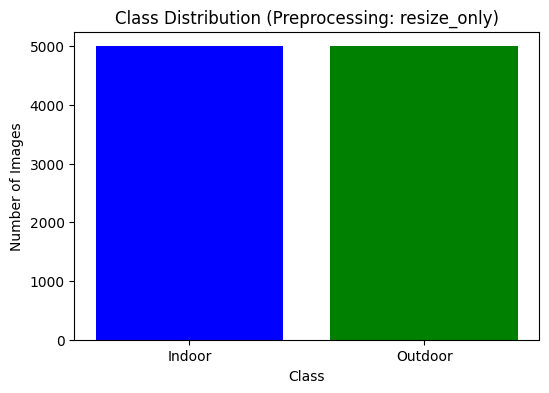

Original Image Dimensions (sample of 10, resize_only): Mean Width=256.0, Mean Height=256.0
Original Image Dimensions Std: Width=0.0, Height=0.0
Mean RGB Values (resize_only): R=108.5, G=115.9, B=121.3
Std of RGB Values (resize_only): R=35.9, G=30.0, B=29.8


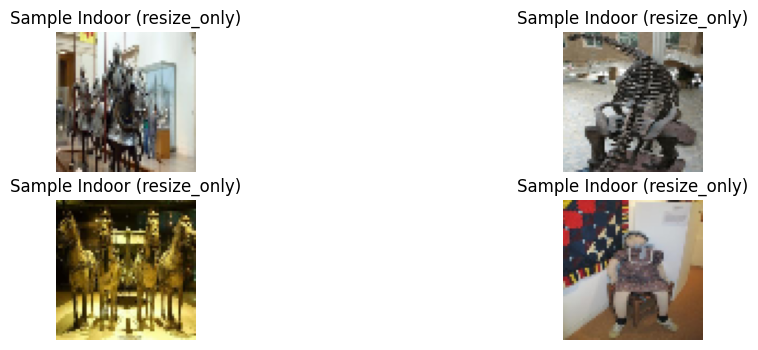


Exploring preprocessing method: normalize
Loaded 10000 training images for normalize.


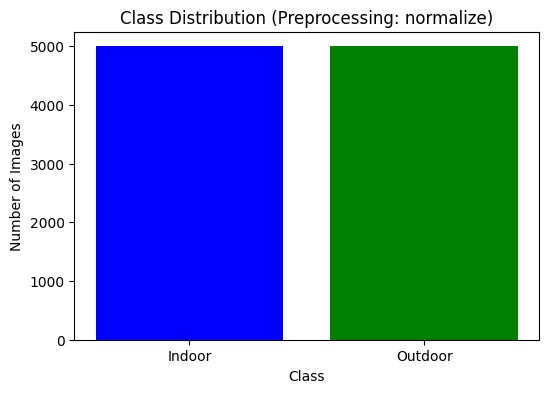

Original Image Dimensions (sample of 10, normalize): Mean Width=256.0, Mean Height=256.0
Original Image Dimensions Std: Width=0.0, Height=0.0
Mean RGB Values (normalize): R=0.4, G=0.5, B=0.5
Std of RGB Values (normalize): R=0.1, G=0.1, B=0.1


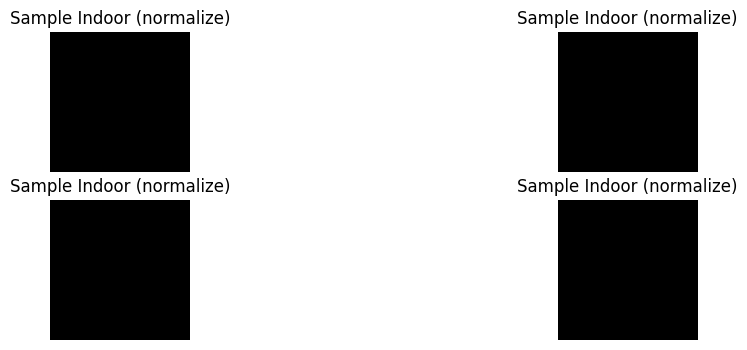


Exploring preprocessing method: grayscale
Loaded 10000 training images for grayscale.


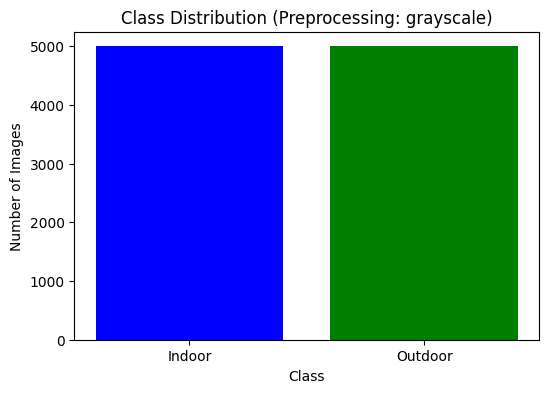

Original Image Dimensions (sample of 10, grayscale): Mean Width=256.0, Mean Height=256.0
Original Image Dimensions Std: Width=0.0, Height=0.0
Mean RGB Values (grayscale): R=116.7, G=116.7, B=116.7
Std of RGB Values (grayscale): R=29.1, G=29.1, B=29.1


<ipython-input-23-9f14732be408>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Mean RGB Values ({method}): R={float(rgb_mean[0]):.1f}, G={float(rgb_mean[1]):.1f}, B={float(rgb_mean[2]):.1f}")
<ipython-input-23-9f14732be408>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Std of RGB Values ({method}): R={float(rgb_std[0]):.1f}, G={float(rgb_std[1]):.1f}, B={float(rgb_std[2]):.1f}")


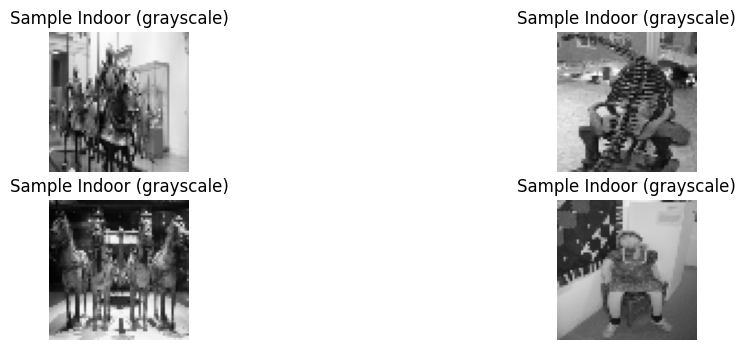


Exploring preprocessing method: histogram_equalization
Loaded 10000 training images for histogram_equalization.


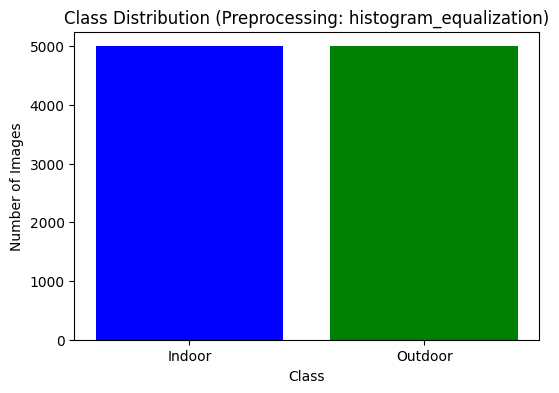

Original Image Dimensions (sample of 10, histogram_equalization): Mean Width=256.0, Mean Height=256.0
Original Image Dimensions Std: Width=0.0, Height=0.0
Mean RGB Values (histogram_equalization): R=120.2, G=127.7, B=132.8
Std of RGB Values (histogram_equalization): R=18.0, G=5.0, B=12.5


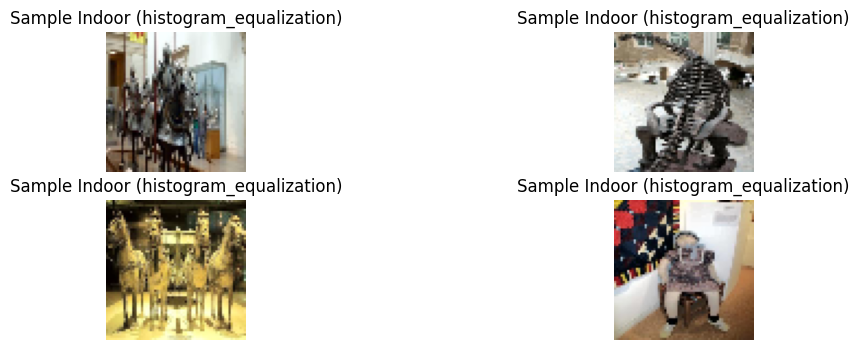


Proceeding with resize_only for modeling and hyperparameter tuning...
Loaded 10000 training images for modeling.

Random Forest (Default) Validation Accuracy: 0.7733

Random Forest (Tuned 1) Validation Accuracy: 0.7793

Random Forest (Tuned 2) Validation Accuracy: 0.7820
Debug - y_val shape: (1500,), y_pred_rf shape: (1500,), y_prob_rf shape: (1500,)

Random Forest Performance:
Accuracy: 0.7820
Precision: 0.7779
Recall: 0.7893
F1-Score: 0.7836
ROC-AUC: 0.8553
Cohen's Kappa: 0.5640
Matthews CC: 0.5641
Confusion Matrix:
[[581 169]
 [158 592]]

Decision Tree (Default) Validation Accuracy: 0.7713

Decision Tree (Tuned 1) Validation Accuracy: 0.7653

Decision Tree (Tuned 2) Validation Accuracy: 0.7747

Decision Tree (Supervised) Performance:
Accuracy: 0.7747
Precision: 0.7910
Recall: 0.7467
F1-Score: 0.7682
ROC-AUC: 0.8216
Cohen's Kappa: 0.5493
Matthews CC: 0.5502
Confusion Matrix:
[[602 148]
 [190 560]]

Gradient Boosting (Default) Validation Accuracy: 0.7813

Gradient Boosting (Tuned 1) 

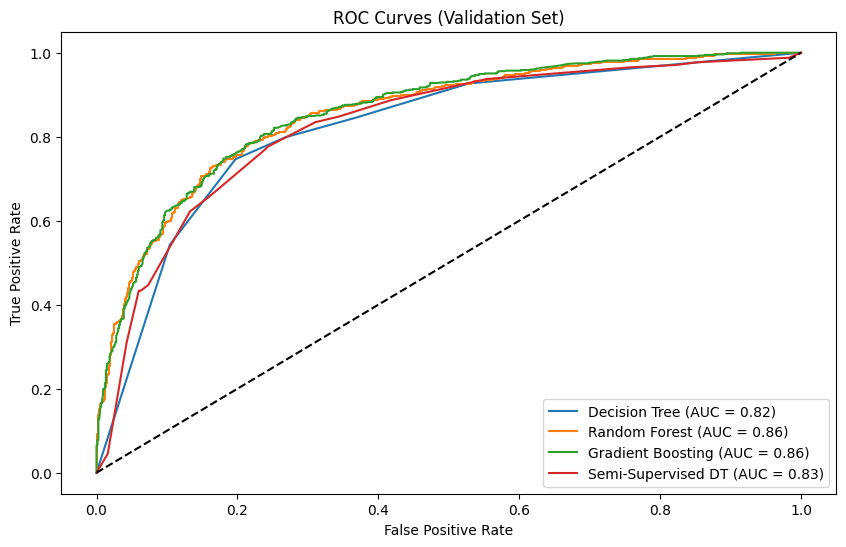

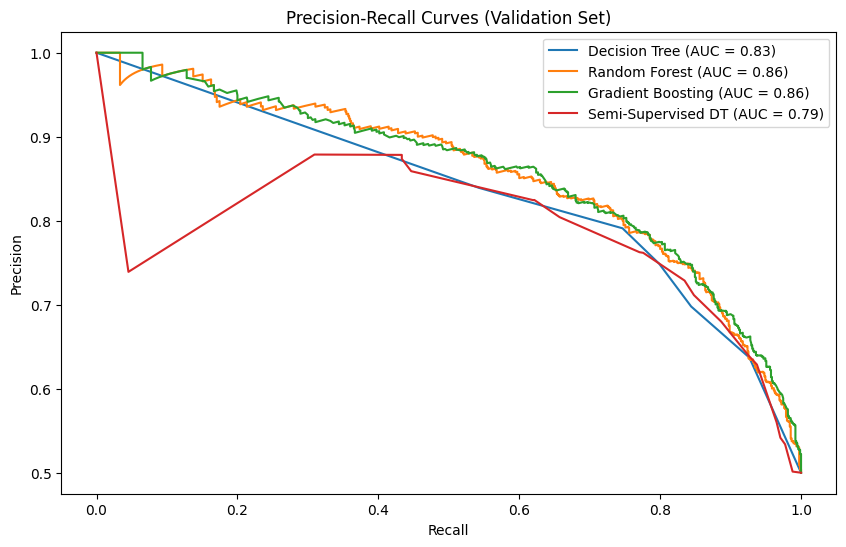

Plotting confusion matrix for Random Forest


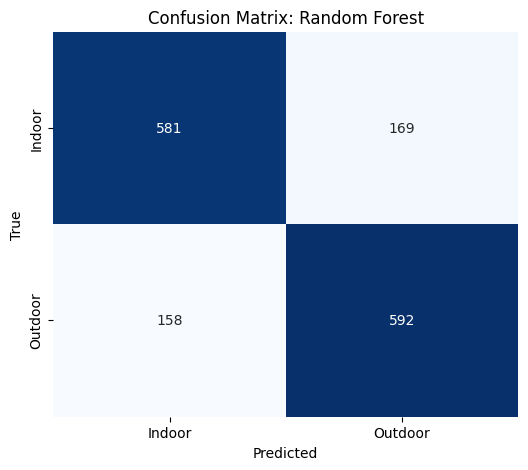

Plotting confusion matrix for Decision Tree


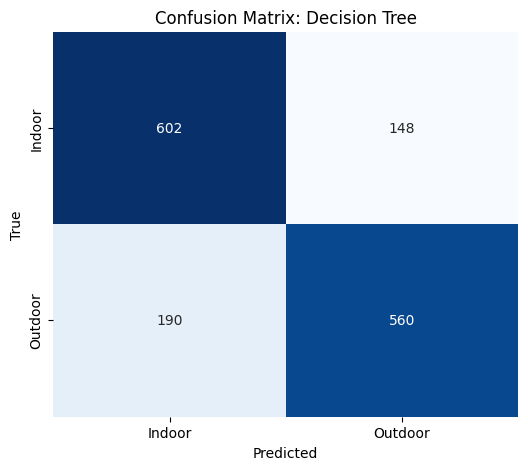

Plotting confusion matrix for Gradient Boosting


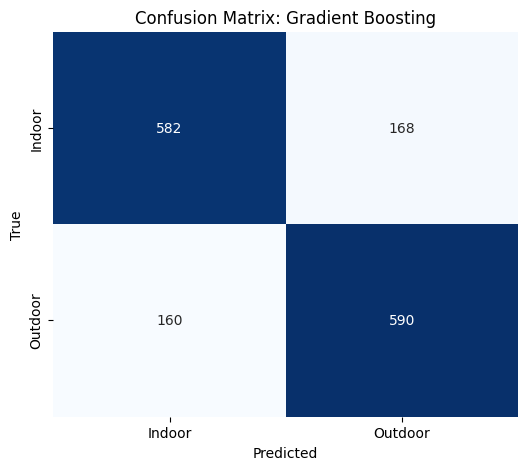

Plotting confusion matrix for Semi-Supervised DT


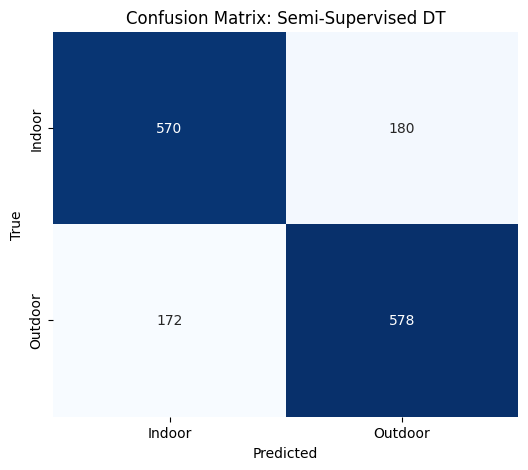

Plotting feature importance for Random Forest


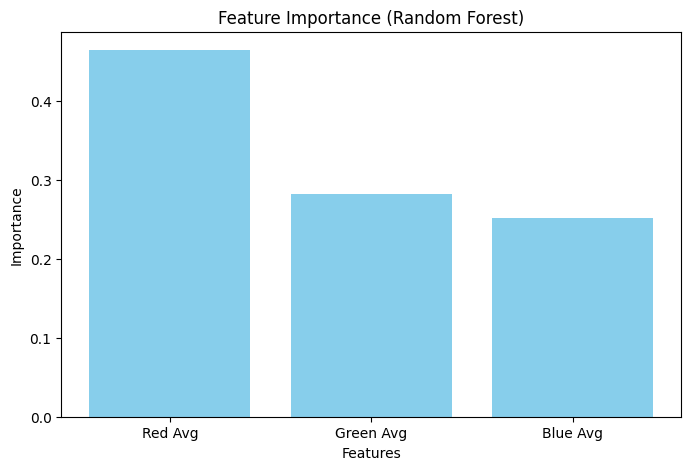

Plotting learning curve for Random Forest


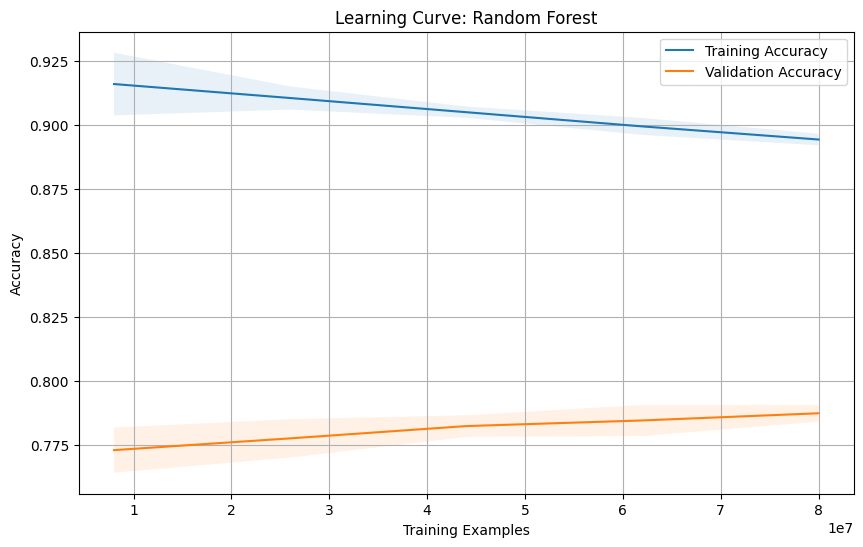

In [27]:
if __name__ == "__main__":
    phase_1()